In [16]:
import pandas as pd 
import numpy as np 
import os

data = pd.read_csv("clean_weather(1).csv", index_col=0)
data = data.ffill()

data

tmax  tmin  rain  tmax_tomorrow
1970-01-01  60.0  35.0   0.0           52.0
1970-01-02  52.0  39.0   0.0           52.0
1970-01-03  52.0  35.0   0.0           53.0
1970-01-04  53.0  36.0   0.0           52.0
1970-01-05  52.0  35.0   0.0           50.0
...          ...   ...   ...            ...
2022-11-22  62.0  35.0   0.0           67.0
2022-11-23  67.0  38.0   0.0           66.0
2022-11-24  66.0  41.0   0.0           70.0
2022-11-25  70.0  39.0   0.0           62.0
2022-11-26  62.0  41.0   0.0           64.0

[13509 rows x 4 columns]

In [17]:
data["tmax"].head(10).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57.]])

In [18]:
data["tmax"].head(6).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50.]])

In [19]:
data["tmax"].head(15).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57., 57., 58., 59.,
        58., 56.]])

In [20]:
data["tmax"]

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
              ... 
2022-11-22    62.0
2022-11-23    67.0
2022-11-24    66.0
2022-11-25    70.0
2022-11-26    62.0
Name: tmax, Length: 13509, dtype: float64

In [21]:
#STEP BY STEP FORWARD PASS

In [22]:
np.random.seed(0)

i_weight = np.random.rand(1,2) 
h_weight = np.random.rand(2,2)
o_weight = np.random.rand(2,1)

temps = data["tmax"].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [23]:
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

In [24]:
x0

array([[66.]])

In [25]:
xi_0 = x0 @ i_weight

xi_0

array([[36.22169126, 47.20249818]])

In [26]:
xh_0 = np.maximum(0, xi_0)

xh_0

array([[36.22169126, 47.20249818]])

In [27]:
xo_0 = xh_0 @ o_weight

xo_0

array([[57.94406231]])

In [30]:
xi_1 = x1 @ i_weight

xh = xh_0 @ h_weight

xh_1 = np.maximum(0, xh + xi_1)

xo_1 = xh_1 @ o_weight 

xo_1

array([[124.54916092]])

In [31]:
xi_2 = x2 @ i_weight
xh = xh_1 @ h_weight
xh_2 = np.maximum(0, xh + xi_2)
xo_2 = xh_2 @ o_weight
xo_2

array([[190.94853131]])

In [32]:
#TANH ACTIVATION FUNCTION

In [33]:
xh_0

array([[36.22169126, 47.20249818]])

In [34]:
xh_1

array([[ 80.24761908, 100.28766177]])

In [36]:
xh_2

array([[124.88411227, 152.84252918]])

$$\tanh = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

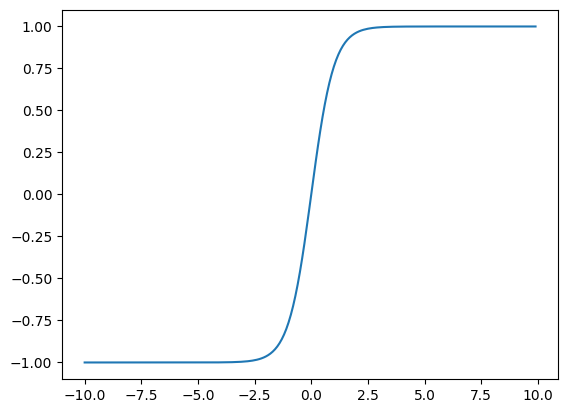

In [38]:
import matplotlib.pyplot as plt

temps = np.arange(-10, 10, .1) 

plt.plot(temps, np.tanh(temps))

In [39]:
from sympy import diff, symbols, exp 

x = symbols("x")
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

$1 - \tanh^2{x}$

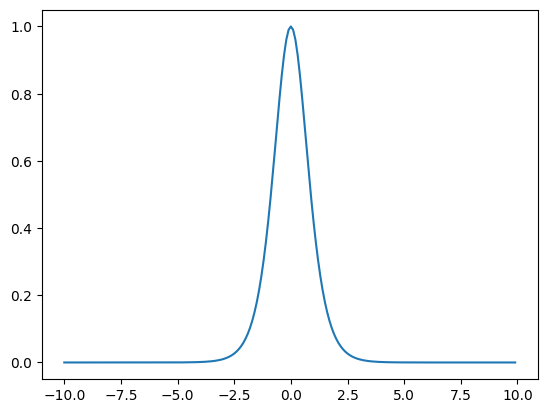

In [40]:
plt.plot(temps, 1-np.tanh(temps) ** 2)

In [41]:
#FULL FORWARD PASS 

In [43]:
np.random.seed(0)

i_weight = np.random.rand(1,5) / 5 - .1 
h_weight = np.random.rand(5,5) / 5 - .1 
h_bias = np.random.rand(1,5) / 5 - .1

o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)

In [ ]:
outputs = np.zeros(3) 
hiddens = np.zeros((3,5))
prev_hidden = None
sequence = data["tmax"].tail(3).to_numpy()

for i in range(3):
    x = sequence[i].reshape(1,1)

    xi = x @ i_weight
    if prev_hidden is None:
        xh = xi
    else:
        xh = xi + prev_hidden @ h_weight + h_bias 

    xh = np.tanh(xh)
    prev_hidden = xh 
    hiddens[i,] = xh 

    xo = xh @ o_weight + o_bias 
    outputs[i] = xo

In [45]:
outputs

array([74.31470595, 80.66149404, 77.67852446])

In [46]:
hiddens

array([[ 0.56784618,  0.99320288,  0.87557333,  0.53166114, -0.76483255],
       [ 0.58366756,  0.99568651,  0.90034879,  0.69338529, -0.84149203],
       [ 0.5383306 ,  0.99164251,  0.86287584,  0.66091071, -0.80543591]])

In [47]:
#FULL BACKWARD PASS

In [48]:
def mse(actual, predicted):
    return np.mean((actual-predicted) ** 2)

def mse_grad(actual, predicted):
    return (predicted-actual)

In [49]:
actuals = np.array([70, 62, 65])

loss_grad = mse_grad(actuals, outputs)
loss_grad

array([ 4.31470595, 18.66149404, 12.67852446])

In [53]:
next_hidden = None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5 

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)

    o_grad = l_grad @ o_weight.T

    if next_hidden is None:
        h_grad = o_grad
    else:
        h_grad = o_grad + next_hidden @ h_weight.T

    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:]
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

In [54]:
i_weight_grad

array([[ 32352.67091083,    392.99655233,   9528.43418739,
         35514.29142052, 146401.10347147]])

In [56]:
lr = 1e-6

i_weight -= i_weight_grad * lr 
h_weight -= h_weight_grad * lr 
h_bias -= h_bias_grad * lr 
o_weight -= o_weight_grad * lr 
o_bias -= o_bias_grad * lr 

In [58]:
i_weight

array([[-0.05494264,  0.04225188,  0.00149581, -0.06205195, -0.30807125]])

In [59]:
#COMPLETE IMPLEMENTATION

In [60]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [61]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [62]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [64]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

In [65]:
epochs = 250
lr = 1e-5

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3122.5944001445105 valid loss 2171.3186862102048
Epoch: 50 train loss 30.593193275313325 valid loss 30.568271740103103
Epoch: 100 train loss 25.26398681354356 valid loss 24.43551751035538
Epoch: 150 train loss 22.95676242953134 valid loss 22.17701097197684
Epoch: 200 train loss 22.30677432770408 valid loss 21.557992202834072
